__Conclusion: less than 1% of the ELGs are "missing" from the catalog, and most of these "missing" objects are actually blends that are detected. The actual rate of undetect ELGs is significantly less than 1%.__

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

from scipy import stats
from IPython.display import Image

sys.path.append(os.path.expanduser('~/git/Python/user_modules/'))
from match_coord import match_coord

import select_desi_targets

In [2]:
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [3]:
ramin, ramax, decmin, decmax = 147.8+1.2, 152.5-1.2, -0.1+1.2, 4.5-1.2
nmad = lambda x: 1.4826*np.nanmedian(np.abs(x-np.nanmedian(x)))

In [5]:
subs = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/data/deep_field_subsets/catalogs/cosmos_subsets_rongpu_dr10.fits'))
print(len(subs))

nobs = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/data/deep_field_subsets/catalogs/cosmos_subsets_rongpu_dr10_nexp_and_maskbits.fits'))
print(len(nobs))

subs = hstack([subs, nobs], join_type='exact')

# # Sanity check
# sub_list = ['dr9_ccds', 'sub-0', 'sub-1', 'sub-2', 'sub-3', 'sub-4', 'sub-5', 'sub-6', 'sub-7', 'sub-8', 'sub-9', 'sub-10']
# for sub in sub_list:
#     mask = subs['sub']==sub
#     print(np.sum(subs['ngood_g'][mask]!=subs[sub+'_ngood_g'][mask]),
#          np.sum(subs['ngood_r'][mask]!=subs[sub+'_ngood_r'][mask]),
#          np.sum(subs['ngood_z'][mask]!=subs[sub+'_ngood_z'][mask]),
#          np.sum(subs['maskbits'][mask]!=subs[sub+'_maskbits'][mask]))

min_nobs = 1
mask = (subs['ngood_g']>=min_nobs) & (subs['ngood_r']>=min_nobs) & (subs['ngood_z']>=min_nobs)
subs = subs[mask]
print(len(subs))

mask = np.full(len(subs), True)
for band in ['g', 'r', 'z']:
    mask &= subs['flux_ivar_'+band]>0
subs = subs[mask]
print(len(subs))

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    subs['gmag'] = 22.5 - 2.5*np.log10(subs['flux_g']) - 3.214 * subs['ebv']
    subs['rmag'] = 22.5 - 2.5*np.log10(subs['flux_r']) - 2.165 * subs['ebv']
    subs['zmag'] = 22.5 - 2.5*np.log10(subs['flux_z']) - 1.211 * subs['ebv']
    subs['w1mag'] = 22.5 - 2.5*np.log10(subs['flux_w1']) - 0.184 * subs['ebv']
    subs['w2mag'] = 22.5 - 2.5*np.log10(subs['flux_w2']) - 0.113 * subs['ebv']
    subs['gmagerr'] = 1/np.sqrt(subs['flux_ivar_g'])/(subs['flux_g'])
    subs['rmagerr'] = 1/np.sqrt(subs['flux_ivar_r'])/(subs['flux_r'])
    subs['zmagerr'] = 1/np.sqrt(subs['flux_ivar_z'])/(subs['flux_z'])
    subs['w1magerr'] = 1/np.sqrt(subs['flux_ivar_w1'])/(subs['flux_w1'])
    subs['w2magerr'] = 1/np.sqrt(subs['flux_ivar_w2'])/(subs['flux_w2'])
    subs['gfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_g']) - 3.214 * subs['ebv']
    subs['rfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_r']) - 2.165 * subs['ebv']
    subs['zfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_z']) - 1.211 * subs['ebv']

3183343
3183343
2752104
2751688


In [6]:
# Remove objects with large sky residuals
for band in ['g', 'r', 'z']:
    subs[band+'_sky'] = (subs['apflux_blobresid_'+band][:, -1]-subs['apflux_blobresid_'+band][:, -2]) / (np.pi*7**2-np.pi*5**2)
mask_quality = (subs['g_sky']>-0.002*2) & (subs['g_sky']<0.002*2)
print(np.sum(mask_quality)/len(mask_quality))
mask_quality &= (subs['r_sky']>-0.003*2) & (subs['r_sky']<0.003*2)
print(np.sum(mask_quality)/len(mask_quality))
mask_quality &= (subs['z_sky']>-0.006*2) & (subs['z_sky']<0.006*2)
print(np.sum(mask_quality)/len(mask_quality))

# Only keep isolated sources
mask_quality &= (subs['fracflux_g']>-0.01) & (subs['fracflux_g']<0.01)
print(np.sum(mask_quality)/len(mask_quality))
mask_quality &= (subs['fracflux_r']>-0.01) & (subs['fracflux_r']<0.01)
print(np.sum(mask_quality)/len(mask_quality))
mask_quality &= (subs['fracflux_z']>-0.01) & (subs['fracflux_z']<0.01)
print(np.sum(mask_quality)/len(mask_quality))

0.9314369943104015
0.883070319018726
0.7825600140713628
0.512725279900919
0.4855695849238722
0.45671238890455607


In [7]:
elglop, elgvlo = select_desi_targets.select_elgs(subs)
print(np.sum(elglop), np.sum(elgvlo))
elglop &= mask_quality
elgvlo &= mask_quality
print(np.sum(elglop), np.sum(elgvlo))

56259 14611
27814 7567


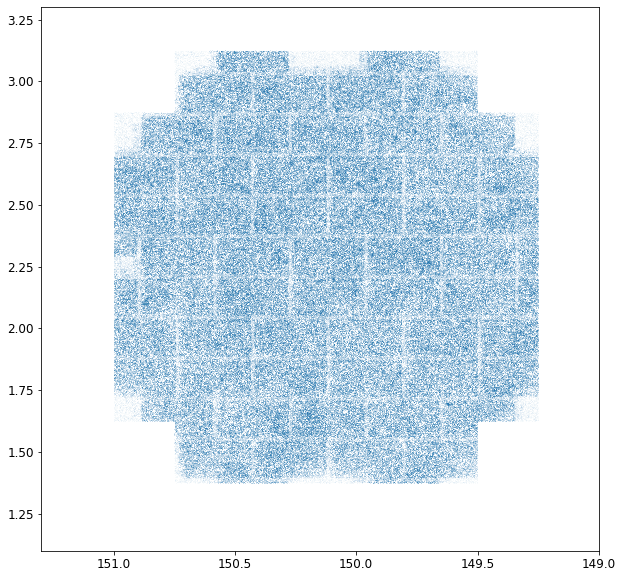

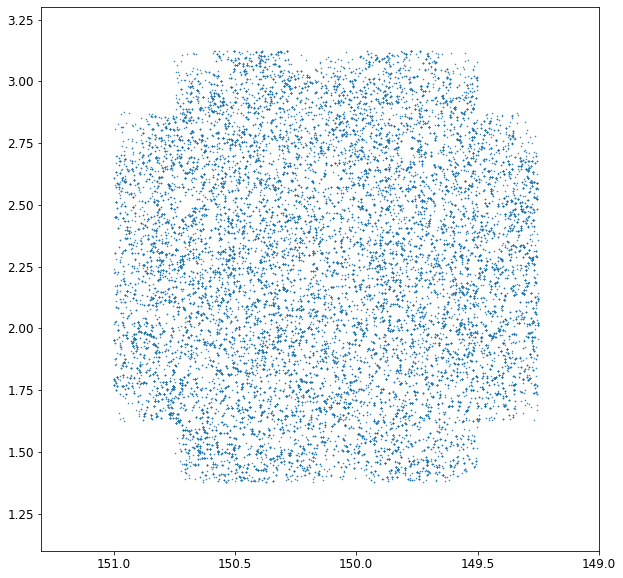

In [8]:
plt.figure(figsize=(10, 10))
plt.plot(subs['ra'], subs['dec'], '.', ms=0.02)
plt.axis([ramin, ramax, decmin, decmax])
plt.gca().invert_xaxis()
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(subs['ra'][elglop], subs['dec'][elglop], '.', ms=1.)
plt.axis([ramin, ramax, decmin, decmax])
plt.gca().invert_xaxis()
plt.show()

--------
## DR9

In [34]:
sub = 'dr9_ccds'
mask = subs['sub']==sub
sub1 = subs[mask].copy()
print(len(sub1))

mask = elglop.copy()
for col in ['ngood_g', 'ngood_r', 'ngood_z']:
    mask &= subs[sub+'_'+col]>=min_nobs

maskbits = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13]
mask_clean = np.ones(len(subs), dtype=bool)
for bit in maskbits:
    mask_clean &= (subs[sub+'_'+'maskbits'] & 2**bit)==0
print(np.sum(~mask_clean)/len(mask_clean))
mask &= mask_clean

subs_elg = subs[mask].copy()
print(len(subs_elg))

242235
0.033605917531348034
27345


Final matched objects = 27029


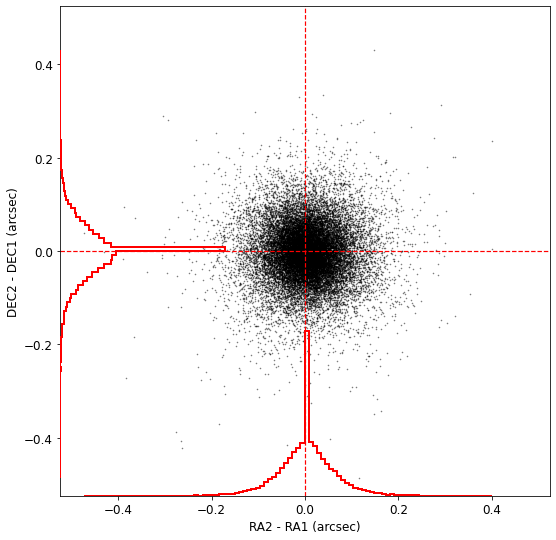

0.9884439568476869


In [35]:
idx1, idx2, d2d, d_ra, d_dec = match_coord(sub1['ra'], sub1['dec'], subs_elg['ra'], subs_elg['dec'], search_radius=0.5, plot_q=True, keep_all_pairs=True)
print(len(idx1)/len(subs_elg))

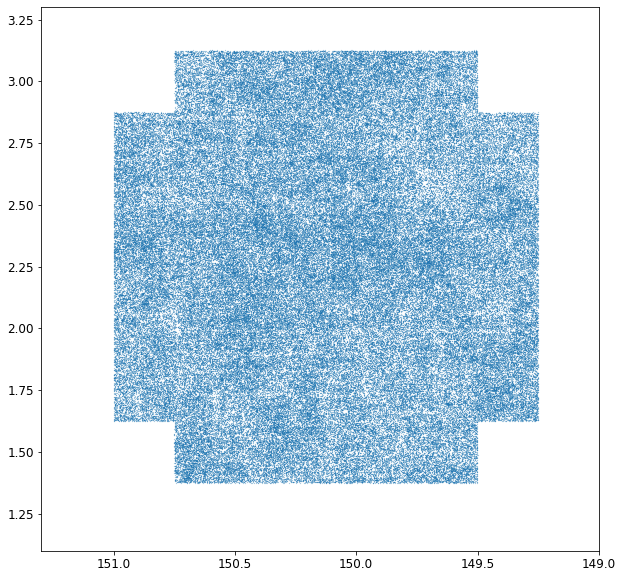

316


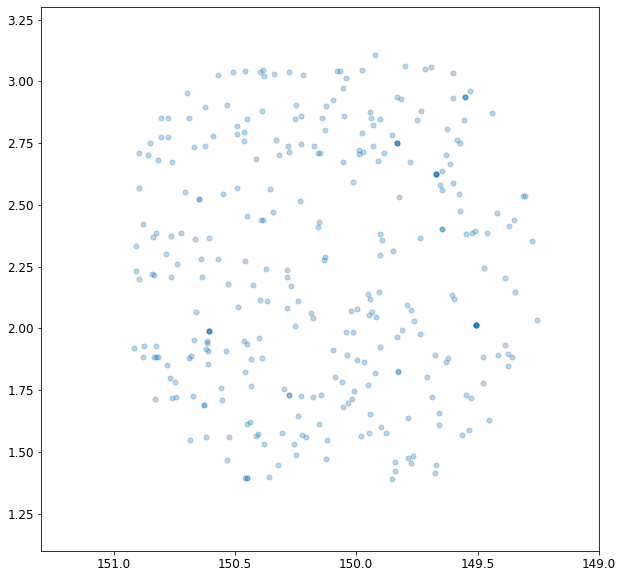

316


In [36]:
plt.figure(figsize=(10, 10))
plt.plot(sub1['ra'], sub1['dec'], '.', ms=0.3)
plt.axis([ramin, ramax, decmin, decmax])
plt.gca().invert_xaxis()
plt.show()

mask = ~np.in1d(np.arange(len(subs_elg)), idx2)
print(np.sum(mask))
plt.figure(figsize=(10, 10))
plt.plot(subs_elg['ra'][mask], subs_elg['dec'][mask], '.', ms=10, alpha=0.3)
plt.axis([ramin, ramax, decmin, decmax])
plt.gca().invert_xaxis()
plt.show()

idx = np.where(mask)[0]
idx = np.random.choice(idx, size=len(idx), replace=False)
print(len(idx))
if len(idx)>200:
    idx = np.random.choice(idx, size=200, replace=False)
else:
    idx = np.random.choice(idx, size=len(idx), replace=False)
tmp = Table()
tmp['RA'] = subs_elg['ra'][idx]
tmp['DEC'] = subs_elg['dec'][idx]
tmp.sort('RA')
tmp.write('/global/u2/r/rongpu/temp/elg_detection/visual_inspection_{}.txt'.format(sub), format='ascii.no_header', overwrite=True)

--------
## DR9 -- deeper subsets only

In [37]:
sub = 'dr9_ccds'
mask = subs['sub']==sub
sub1 = subs[mask].copy()
print(len(sub1))

mask = np.full(len(subs), False)
for index in range(6, 11):
    mask |= subs['sub']=='sub-{}'.format(index)
mask &= elglop
for col in ['ngood_g', 'ngood_r', 'ngood_z']:
    mask &= subs[sub+'_'+col]>=min_nobs

maskbits = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13]
mask_clean = np.ones(len(subs), dtype=bool)
for bit in maskbits:
    mask_clean &= (subs[sub+'_'+'maskbits'] & 2**bit)==0
print(np.sum(~mask_clean)/len(mask_clean))
mask &= mask_clean

subs_elg = subs[mask].copy()
print(len(subs_elg))

242235
0.033605917531348034
11561


Final matched objects = 11492


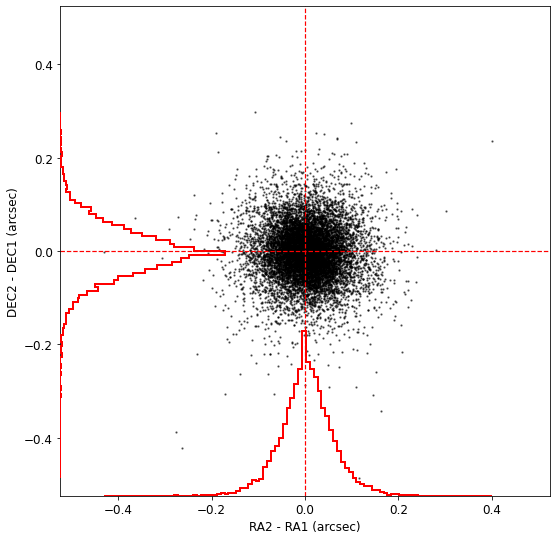

0.9940316581610588


In [38]:
idx1, idx2, d2d, d_ra, d_dec = match_coord(sub1['ra'], sub1['dec'], subs_elg['ra'], subs_elg['dec'], search_radius=0.5, plot_q=True, keep_all_pairs=True)
print(len(idx1)/len(subs_elg))

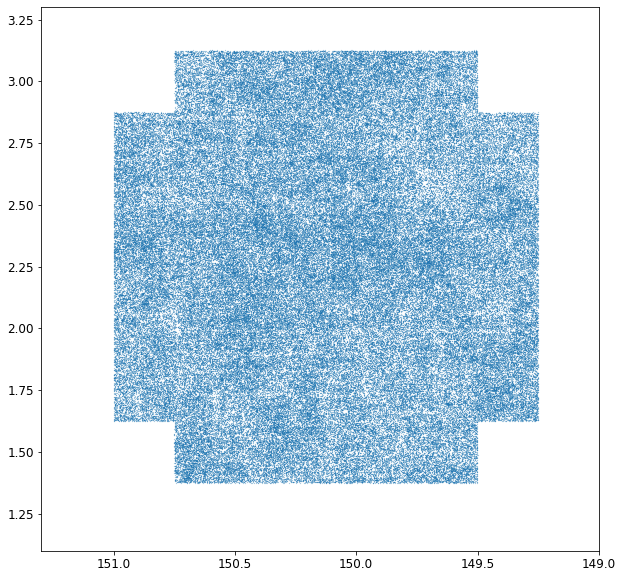

69


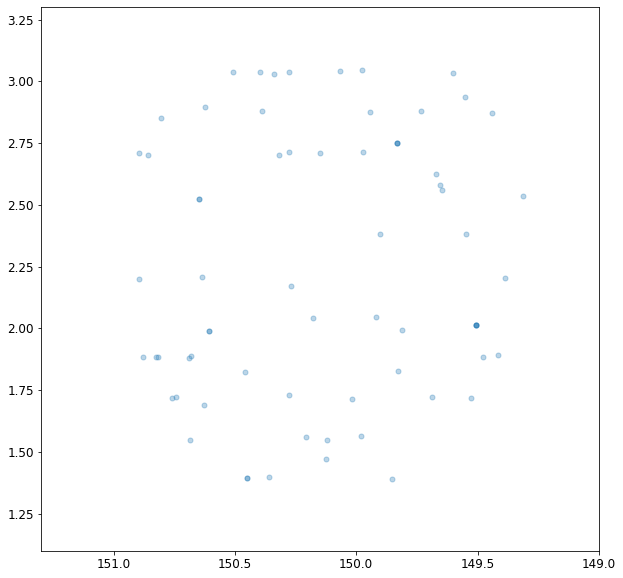

69


In [39]:
plt.figure(figsize=(10, 10))
plt.plot(sub1['ra'], sub1['dec'], '.', ms=0.3)
plt.axis([ramin, ramax, decmin, decmax])
plt.gca().invert_xaxis()
plt.show()

mask = ~np.in1d(np.arange(len(subs_elg)), idx2)
print(np.sum(mask))
plt.figure(figsize=(10, 10))
plt.plot(subs_elg['ra'][mask], subs_elg['dec'][mask], '.', ms=10, alpha=0.3)
plt.axis([ramin, ramax, decmin, decmax])
plt.gca().invert_xaxis()
plt.show()

idx = np.where(mask)[0]
idx = np.random.choice(idx, size=len(idx), replace=False)
print(len(idx))
if len(idx)>200:
    idx = np.random.choice(idx, size=200, replace=False)
else:
    idx = np.random.choice(idx, size=len(idx), replace=False)
tmp = Table()
tmp['RA'] = subs_elg['ra'][idx]
tmp['DEC'] = subs_elg['dec'][idx]
tmp.sort('RA')
tmp.write('/global/u2/r/rongpu/temp/elg_detection/visual_inspection_{}_1.txt'.format(sub), format='ascii.no_header', overwrite=True)

--------
## sub-1

In [32]:
sub = 'sub-1'
mask = subs['sub']==sub
sub1 = subs[mask].copy()
print(len(sub1))

mask = elglop.copy()
for col in ['ngood_g', 'ngood_r', 'ngood_z']:
    mask &= subs[sub+'_'+col]>=min_nobs

maskbits = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13]
mask_clean = np.ones(len(subs), dtype=bool)
for bit in maskbits:
    mask_clean &= (subs[sub+'_'+'maskbits'] & 2**bit)==0
print(np.sum(~mask_clean)/len(mask_clean))
mask &= mask_clean

subs_elg = subs[mask].copy()
print(len(subs_elg))

148170
0.03641582912016188
20614


Final matched objects = 20387


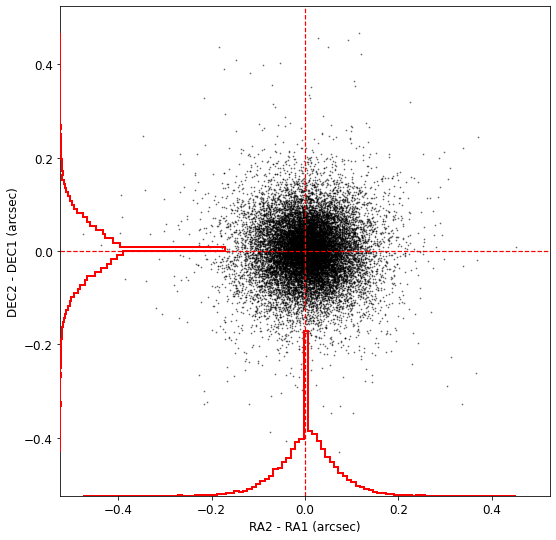

0.9889880663626661


In [33]:
idx1, idx2, d2d, d_ra, d_dec = match_coord(sub1['ra'], sub1['dec'], subs_elg['ra'], subs_elg['dec'], search_radius=0.5, plot_q=True, keep_all_pairs=True)
print(len(idx1)/len(subs_elg))

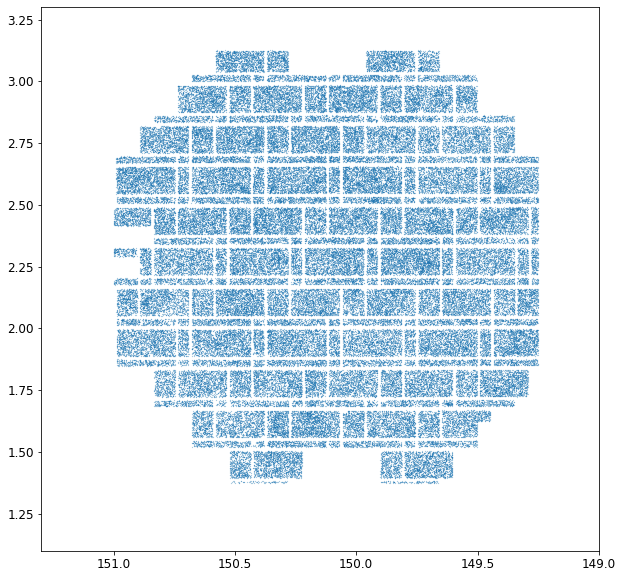

227


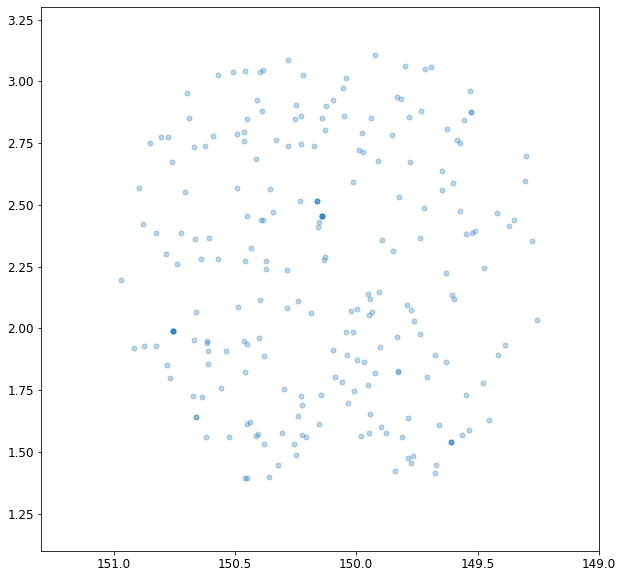

In [17]:
plt.figure(figsize=(10, 10))
plt.plot(sub1['ra'], sub1['dec'], '.', ms=0.3)
plt.axis([ramin, ramax, decmin, decmax])
plt.gca().invert_xaxis()
plt.show()

mask = ~np.in1d(np.arange(len(subs_elg)), idx2)
print(np.sum(mask))
plt.figure(figsize=(10, 10))
plt.plot(subs_elg['ra'][mask], subs_elg['dec'][mask], '.', ms=10, alpha=0.3)
plt.axis([ramin, ramax, decmin, decmax])
plt.gca().invert_xaxis()
plt.show()

--------
## sub-1 -- deeper subsets only

In [18]:
sub = 'sub-1'
mask = subs['sub']==sub
sub1 = subs[mask].copy()
print(len(sub1))

mask = np.full(len(subs), False)
for index in range(6, 11):
    mask |= subs['sub']=='sub-{}'.format(index)
mask &= elglop
for col in ['ngood_g', 'ngood_r', 'ngood_z']:
    mask &= subs[sub+'_'+col]>=min_nobs

maskbits = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13]
mask_clean = np.ones(len(subs), dtype=bool)
for bit in maskbits:
    mask_clean &= (subs[sub+'_'+'maskbits'] & 2**bit)==0
print(np.sum(~mask_clean)/len(mask_clean))
mask &= mask_clean

subs_elg = subs[mask].copy()
print(len(subs_elg))

148170
0.03641582912016188
8402


Final matched objects = 8373


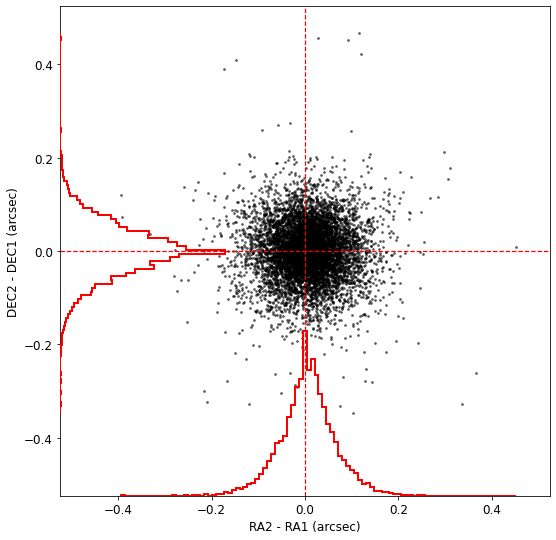

0.9965484408474172


In [19]:
idx1, idx2, d2d, d_ra, d_dec = match_coord(sub1['ra'], sub1['dec'], subs_elg['ra'], subs_elg['dec'], search_radius=0.5, plot_q=True, keep_all_pairs=True)
print(len(idx1)/len(subs_elg))

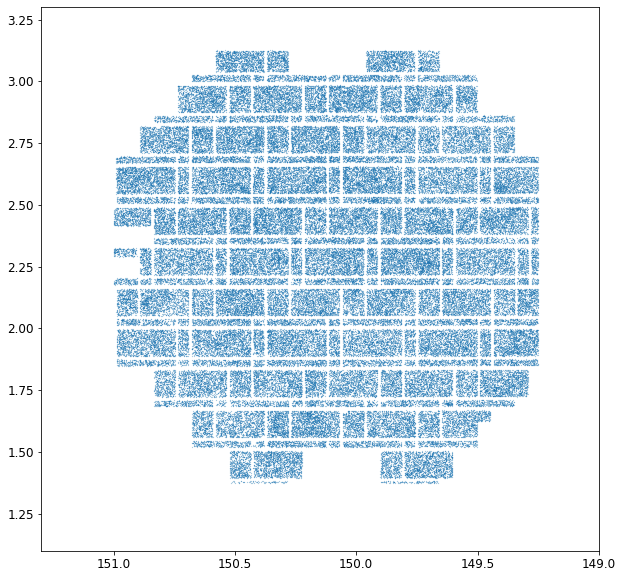

29


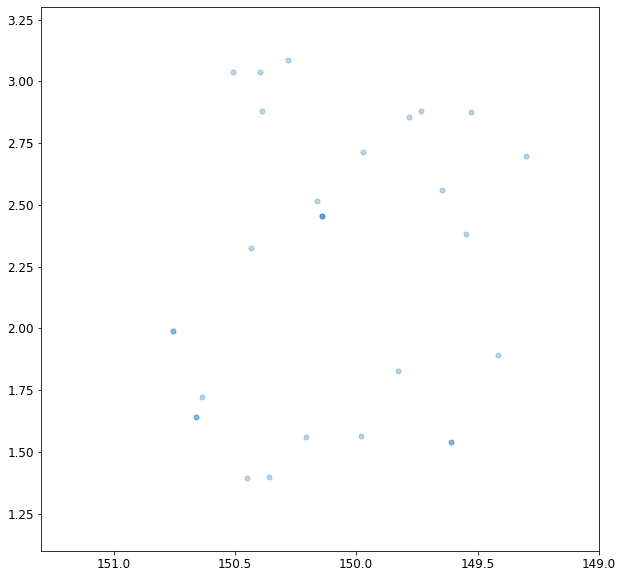

In [20]:
plt.figure(figsize=(10, 10))
plt.plot(sub1['ra'], sub1['dec'], '.', ms=0.3)
plt.axis([ramin, ramax, decmin, decmax])
plt.gca().invert_xaxis()
plt.show()

mask = ~np.in1d(np.arange(len(subs_elg)), idx2)
print(np.sum(mask))
plt.figure(figsize=(10, 10))
plt.plot(subs_elg['ra'][mask], subs_elg['dec'][mask], '.', ms=10, alpha=0.3)
plt.axis([ramin, ramax, decmin, decmax])
plt.gca().invert_xaxis()
plt.show()